In [1]:
!pip install openpyxl

     |████████████████████████████████| 242 kB 594 kB/s            


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pprint import pprint as pp
import matplotlib.pyplot as plt
import seaborn as sns
sns.style = 'white'

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# path_list = []
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
# #         print(os.path.join(dirname, filename))
#         path_list.append(os.path.join(dirname, filename))
# pp(path_list)

path_list = []
years = [2018, 2019]
months = list(range(1, 13))
seq_size = 60
ground_truth = 1000
file_dir = '/kaggle/input/dunedinbox74/Dunedin-Box74/'
for year in years:
    for month in months:
        file_path = os.path.join(file_dir, "Dunedin-" + str(year) + "-Month-" + str(month) + '.xlsx')
        path_list.append(file_path)

pp(path_list)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['/kaggle/input/dunedinbox74/Dunedin-Box74/Dunedin-2018-Month-1.xlsx',
 '/kaggle/input/dunedinbox74/Dunedin-Box74/Dunedin-2018-Month-2.xlsx',
 '/kaggle/input/dunedinbox74/Dunedin-Box74/Dunedin-2018-Month-3.xlsx',
 '/kaggle/input/dunedinbox74/Dunedin-Box74/Dunedin-2018-Month-4.xlsx',
 '/kaggle/input/dunedinbox74/Dunedin-Box74/Dunedin-2018-Month-5.xlsx',
 '/kaggle/input/dunedinbox74/Dunedin-Box74/Dunedin-2018-Month-6.xlsx',
 '/kaggle/input/dunedinbox74/Dunedin-Box74/Dunedin-2018-Month-7.xlsx',
 '/kaggle/input/dunedinbox74/Dunedin-Box74/Dunedin-2018-Month-8.xlsx',
 '/kaggle/input/dunedinbox74/Dunedin-Box74/Dunedin-2018-Month-9.xlsx',
 '/kaggle/input/dunedinbox74/Dunedin-Box74/Dunedin-2018-Month-10.xlsx',
 '/kaggle/input/dunedinbox74/Dunedin-Box74/Dunedin-2018-Month-11.xlsx',
 '/kaggle/input/dunedinbox74/Dunedin-Box74/Dunedin-2018-Month-12.xlsx',
 '/kaggle/input/dunedinbox74/Dunedin-Box74/Dunedin-2019-Month-1.xlsx',
 '/kaggle/input/dunedinbox74/Dunedin-Box74/Dunedin-2019-Month-2.xlsx',
 '/

In [3]:
df_train_list = [pd.read_excel(month, index_col='Date_Time', parse_dates=True) 
                 for month in path_list[:2]]
df_train = pd.concat(df_train_list)

# only use "CO2" in experiment
X_train = df_train.drop(columns=['Temp', 'Humid'])
X_train = X_train[~X_train.index.duplicated()]
X_train.describe()

/opt/conda/lib/python3.7/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,CO2
count,84079.000000
mean,472.673533
std,226.958872
min,383.000000
25%,411.000000
50%,416.000000
75%,431.000000
max,2718.000000


In [4]:
df_test_list = [pd.read_excel(month, index_col='Date_Time', parse_dates=True) 
                 for month in path_list[2:4]]
df_test = pd.concat(df_test_list)

# only use "CO2" in experiment
X_test = df_test.drop(columns=['Temp', 'Humid'])
X_test = X_test[~X_test.index.duplicated()]
X_test.describe()

/opt/conda/lib/python3.7/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,CO2
count,86988.000000
mean,502.072148
std,262.967129
min,385.000000
25%,404.000000
50%,414.000000
75%,445.000000
max,2547.000000


In [5]:
X_test.iloc[seq_size]

CO2    437.0
Name: 2018-03-01 01:00:00, dtype: float64

In [6]:
y_train = (X_train['CO2'] > ground_truth).astype(int)
y_test = (X_test['CO2'] > ground_truth).astype(int)

In [7]:
# sum(X_train['CO2'] <= 1000)

In [8]:
# seq_size = 10
def to_seq(x,seq_size=seq_size):
    '''
    assign the label (y) to be the label of the next point of the sequence, not the last opint of the sequence.
    '''
    x_values = []
#     y_values = []
    
    for i in range(len(x) - seq_size + 1):
        x_values.append(x[i:(i+seq_size)])
#         y_values.append(y.iloc[i+seq_size])
#         y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values)#, np.array(y_values)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train_y0 = X_train[X_train['CO2'] <= ground_truth]

scaler = StandardScaler()
X_train_y0_scaled = scaler.fit_transform(X_train_y0)
X_test_scaled = scaler.transform(X_test)
print(scaler.mean_, scaler.var_)
# sequentialize training and test set
train_X = to_seq(X_train_y0_scaled)
test_X = to_seq(X_test_scaled)
print(train_X.shape, test_X.shape)

# train_X, train_y = to_seq(X_train[['CO2']], y_train)
# test_X, test_y = to_seq(X_test[['CO2']], y_test)
# indices = np.all(np.all(train_X <= 1000, axis=1) == True, axis=1)
# train_X_selective = train_X[indices]
# train_y_selective = train_y[indices]
# train_X_y0 = train_X_selective[train_y_selective == 0]
# train_X_y1 = train_X_selective[train_y_selective == 1]

[433.63424705] [4453.36289695]
(81075, 60, 1) (86929, 60, 1)


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def flatten(X, seq_lenth):
    flatten_X = np.empty((X.shape[0]+seq_lenth-1, X.shape[2]))
    flatten_X[:seq_lenth-1] = X[0, :seq_lenth-1, :]
    for i in range(X.shape[0]):
        flatten_X[i+seq_lenth-1] = X[i, seq_lenth-1, :]
    return flatten_X

def scale(X, scaler):
    X_scaled = np.empty(X.shape)
    for i in range(X.shape[0]):
        X_scaled[i] = scaler.transform(X[i])
        
    return X_scaled

def inverseScale(X, scaler):
    X_scaled = np.empty(X.shape)
    for i in range(X.shape[0]):
        X_scaled[i] = scaler.inverse_transform(X[i])
        
    return X_scaled

In [11]:
# scaler = StandardScaler().fit(flatten(train_X_y0, seq_size))
# print(scaler.mean_, scaler.var_)
# train_X_y0_scaled = scale(train_X_y0, scaler)
# print(train_X_y0_scaled.shape)

# test_X_scaled = scale(test_X, scaler)

## Autoencoder LSTM

In [12]:
from tensorflow.keras import layers, Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

callback = EarlyStopping(patience=3, mode='min')

units = 16
model = Sequential()
model.add(layers.LSTM(units, activation='tanh', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dropout(rate=0.2))
model.add(layers.RepeatVector(train_X.shape[1]))
model.add(layers.LSTM(units, activation='tanh', return_sequences=True))
model.add(layers.Dropout(rate=0.2))
model.add(layers.TimeDistributed(layers.Dense(train_X.shape[2])))
model.compile(optimizer='adam', loss='mse')
model.summary()

2022-03-10 05:00:18.242164: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 05:00:18.342740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 05:00:18.343524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-10 05:00:18.344751: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                1152      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 60, 16)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 16)            2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 16)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 60, 1)             17        
Total params: 3,281
Trainable params: 3,281
Non-trainable params: 0
______________________________________________________

In [13]:
history = model.fit(train_X, train_X, batch_size=32, epochs=50, validation_split=0.2, callbacks=[callback])

2022-03-10 05:00:21.036551: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-03-10 05:00:24.126788: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2027/2027 [==============================] - 22s 9ms/step - loss: 0.1515 - val_loss: 0.2952
Epoch 2/50
2027/2027 [==============================] - 16s 8ms/step - loss: 0.0983 - val_loss: 0.1912
Epoch 3/50
2027/2027 [==============================] - 17s 8ms/step - loss: 0.0790 - val_loss: 0.1580
Epoch 4/50
2027/2027 [==============================] - 16s 8ms/step - loss: 0.0696 - val_loss: 0.1579
Epoch 5/50
2027/2027 [==============================] - 16s 8ms/step - loss: 0.0630 - val_loss: 0.1521
Epoch 6/50
2027/2027 [==============================] - 16s 8ms/step - loss: 0.0596 - val_loss: 0.1271
Epoch 7/50
2027/2027 [==============================] - 16s 8ms/step - loss: 0.0566 - val_loss: 0.1371
Epoch 8/50
2027/2027 [==============================] - 16s 8ms/step - loss: 0.0536 - val_loss: 0.1410
Epoch 9/50
2027/2027 [==============================] - 17s 8ms/step - loss: 0.0530 - val_loss: 0.1214
Epoch 10/50
2027/2027 [==============================] - 16s 8ms/step - loss: 0.0518

In [14]:
def meanTrend(y_pred):
    length = y_pred.shape[0]
    width = y_pred.shape[1]
    y = y_pred.reshape(length, width)
    print(y.shape)
    zero_arr = np.zeros((length, length+width-1))
    print(zero_arr.shape)
    for i in range(length):
        zero_arr[i, i:i+width] = y[i,:]
    print(zero_arr[0])
    print(zero_arr[-1])
    err_arr = np.true_divide(zero_arr.sum(0), (zero_arr!=0).sum(0))
    return err_arr.reshape(1, -1)

In [15]:
train_X_pred = model.predict(train_X)
train_X_flatten_pred = meanTrend(train_X_pred)
print(train_X_pred.shape, train_X_flatten_pred.shape)

(81075, 60)
(81075, 81134)
[-0.27513266 -0.29765818 -0.3005487  ...  0.          0.
  0.        ]
[0.         0.         0.         ... 0.08059728 0.08042189 0.080246  ]
(81075, 60, 1) (1, 81134)


In [16]:
# train_X_flatten_pred = flatten(train_X_pred, seq_size)
#train_X_flatten_pred = meanTrend(train_X_pred)
# train_X_y0_flatten = flatten(train_X_y0_scaled, seq_size)

In [17]:
# print(train_X_flatten_pred.shape)
# print(train_X_y0_flatten.shape)

In [18]:
train_X_flatten_pred

array([[-0.27513266, -0.28616379, -0.29062714, ...,  0.08012132,
         0.08019082,  0.080246  ]])

In [19]:
X_train_y0_scaled.shape

(81134, 1)

In [20]:
from sklearn.metrics import mean_absolute_error
# mae = np.mean(np.abs(train_X_flatten_pred - train_X_y0_flatten), axis=1)
mae = mean_absolute_error(X_train_y0_scaled.T, train_X_flatten_pred, multioutput='raw_values')
threshold = np.max(mae)
# threshold = np.percentile(mae, 95)
print(f"threshold = {threshold:.3f}")
mae.shape

threshold = 4.233


(81134,)

In [21]:
# mae = np.mean(np.abs(train_X_pred - train_X_y0_scaled), axis=1)
# threshold = np.max(mae)
# # threshold = np.percentile(mae, 95)
# print(f"threshold = {threshold:.3f}")
# mae.shape

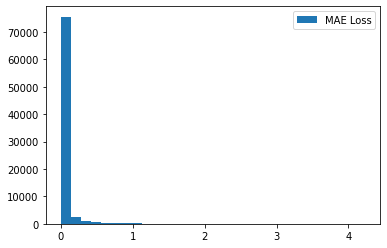

In [22]:
# plot MAE loss distribution of training set
plt.hist(np.squeeze(mae), bins=30, label='MAE Loss')
plt.legend()
plt.show()

In [23]:
test_X_pred = model.predict(test_X)
# test_X_flatten_pred = flatten(test_X_pred, seq_size)
test_X_flatten_pred = meanTrend(test_X_pred)
# test_X_flatten = flatten(test_X_scaled, seq_size)
# mae_test = np.mean(np.abs(test_X_flatten_pred - test_X_flatten), axis=1)

(86929, 60)
(86929, 86988)
[0.06298837 0.06972422 0.05817501 ... 0.         0.         0.        ]
[0.         0.         0.         ... 1.90962338 1.894382   1.87955332]


In [24]:
mae_test = mean_absolute_error(X_test_scaled.T, test_X_flatten_pred, multioutput='raw_values')
mae_test.shape

(86988,)

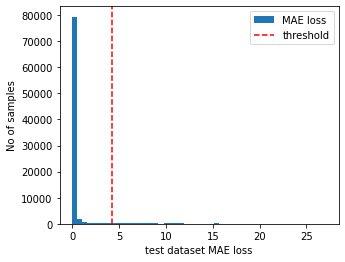

In [25]:
# plot MAE loss distribution of test set
plt.figure(figsize=(5,4))
plt.hist(mae_test, bins=50, label="MAE loss")
plt.axvline(x=threshold, color='r', ls='--', label='threshold')
plt.xlabel("test dataset MAE loss")
plt.ylabel("No of samples")
plt.legend()
plt.show()

In [26]:
# test_score_df = pd.DataFrame(X_test[seq_size:])
test_score_df = X_test.copy()
# test_score_df = test_score_df.iloc[:-1, :]
print(test_score_df.shape)
test_score_df['loss'] = mae_test
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = (test_score_df['loss'] > test_score_df['threshold']).astype(int)
test_score_df['label'] = y_test
# test_score_df['CO2'] = scaler.inverse_transform(test_score_df['CO2'])
test_score_df.head()

(86988, 1)


,CO2,loss,threshold,anomaly,label
Date_Time,,,,,
2018-03-01 00:00:00,439.0,0.017417,4.232662,0,0
2018-03-01 00:01:00,438.0,0.000555,4.232662,0,0
2018-03-01 00:02:00,439.0,0.017415,4.232662,0,0
2018-03-01 00:03:00,439.0,0.019780,4.232662,0,0
2018-03-01 00:04:00,439.0,0.020546,4.232662,0,0


In [27]:
test_score_df.tail()

,CO2,loss,threshold,anomaly,label
Date_Time,,,,,
2018-04-30 23:55:00,574.0,0.191344,4.232662,0,0
2018-04-30 23:56:00,575.0,0.214595,4.232662,0,0
2018-04-30 23:57:00,575.0,0.222806,4.232662,0,0
2018-04-30 23:58:00,576.0,0.245434,4.232662,0,0
2018-04-30 23:59:00,575.0,0.238809,4.232662,0,0


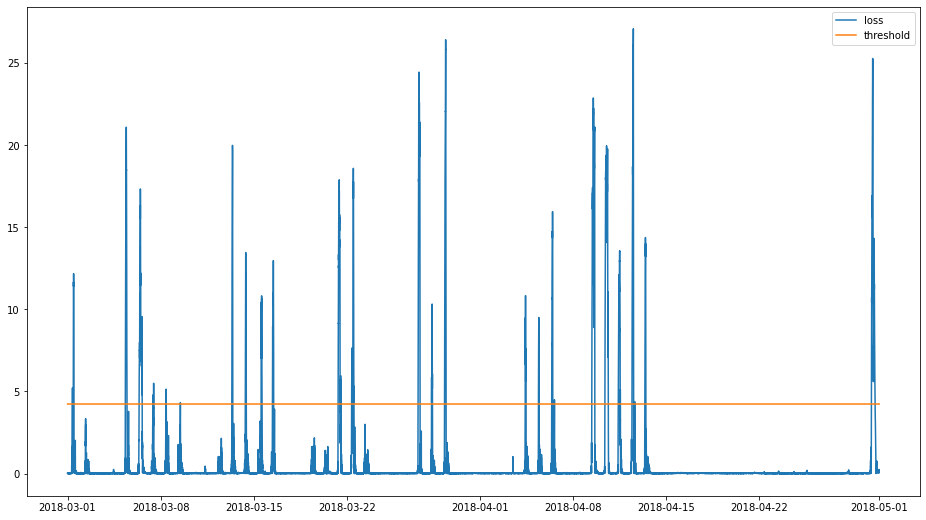

In [28]:
plt.figure(figsize=(16,9))
plt.plot(test_score_df.index, test_score_df['loss'], label='loss')
plt.plot(test_score_df.index, test_score_df['threshold'], label='threshold')
plt.legend()
plt.show()

In [29]:
anomolies_test = test_score_df.loc[test_score_df['anomaly'] == 1]
anomolies_test

,CO2,loss,threshold,anomaly,label
Date_Time,,,,,
2018-03-01 08:37:00,1114.0,4.240371,4.232662,1,1
2018-03-01 08:38:00,1120.0,4.325783,4.232662,1,1
2018-03-01 08:39:00,1121.0,4.334863,4.232662,1,1
2018-03-01 08:40:00,1130.0,4.462390,4.232662,1,1
2018-03-01 08:41:00,1127.0,4.408709,4.232662,1,1
...,...,...,...,...,...
2018-04-30 16:32:00,1135.0,4.433439,4.232662,1,1
2018-04-30 16:33:00,1133.0,4.388570,4.232662,1,1
2018-04-30 16:34:00,1132.0,4.361294,4.232662,1,1


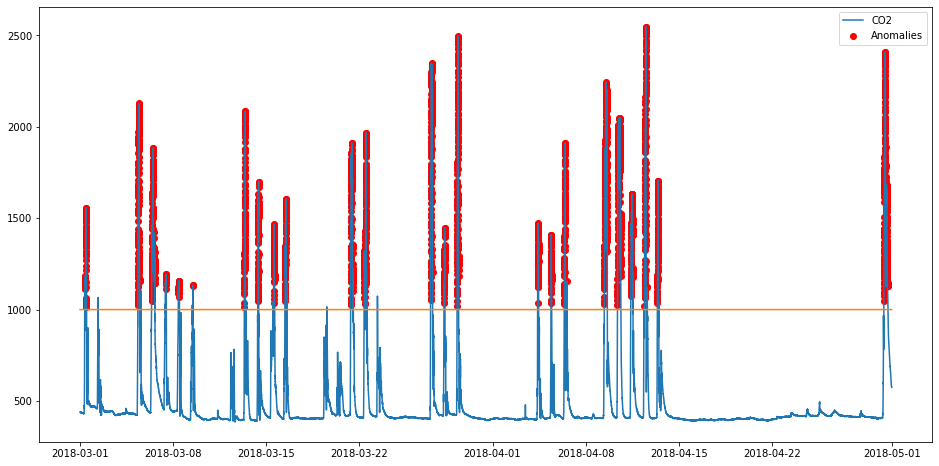

In [30]:
plt.figure(figsize=(16,8))
plt.plot(test_score_df.index, test_score_df['CO2'], label='CO2')
plt.scatter(anomolies_test.index, anomolies_test['CO2'], color='red', label='Anomalies')
plt.plot(test_score_df.index, [ground_truth]*len(test_score_df.index))
plt.legend()
plt.show()

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

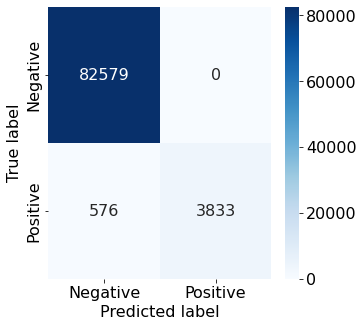

In [32]:
plt.rcParams['font.size'] = '16'
matrix = confusion_matrix(test_score_df['label'], test_score_df['anomaly'])
tn, fp, fn, tp = matrix.ravel()
ticklabels = ['Negative', 'Positive']
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(matrix, ax=ax, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=ticklabels, yticklabels=ticklabels)
plt.xlabel('Predicted label', fontsize=16)
plt.ylabel('True label', fontsize=16)
plt.show()

precision = 1.0
recall = 0.8693581310954865
accuracy = 0.9933783970202786
F1 = 0.9301140499878671


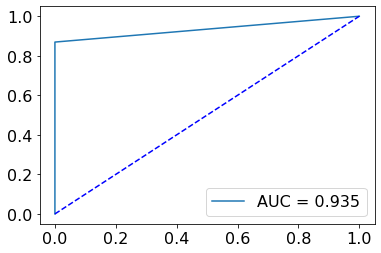

In [33]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print(f"precision = {precision}")
print(f"recall = {recall}")

Accuracy = (tp + tn) / (tp + tn + fp + fn)
F1 = 2 * precision * recall / (precision + recall)
print(f"accuracy = {Accuracy}")
print(f"F1 = {F1}")

fpr, tpr, _ = roc_curve(test_score_df['label'], test_score_df['anomaly'])
roc_auc = roc_auc_score(test_score_df['label'], test_score_df['anomaly'])
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:0.3f}' )
plt.plot([0,1], [0,1], '--b')
plt.legend(loc='lower right')
plt.show()